# Notebook for visualising manuscript embeddings

Load manuscript images

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms

image_size = 500

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size-1),
                                transforms.ToTensor()])
manuscript_dataset = datasets.ImageFolder('../data/images/', transform=transform)
manuscript_label_to_name =  {value:key for key, value in manuscript_dataset.class_to_idx.items()}

manuscript_dataloader = torch.utils.data.DataLoader(manuscript_dataset, batch_size=128, shuffle=False)

image_batch, label_batch = next(iter(manuscript_dataloader))

In [2]:
page_numbers = [name[0].split(".")[-2].split("-")[-1] for name in manuscript_dataset.imgs]

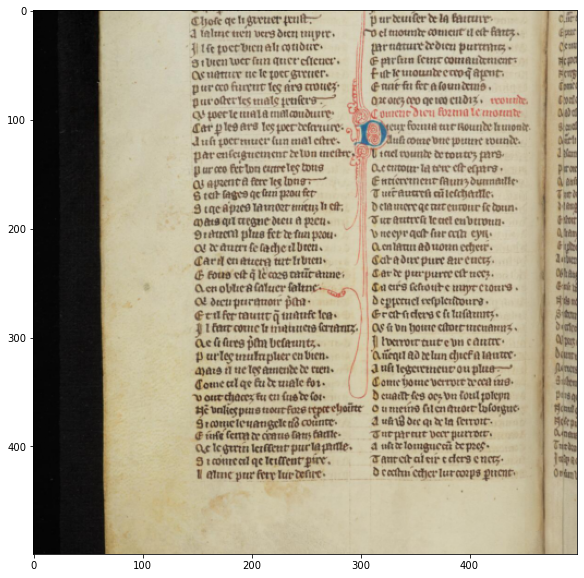

In [3]:
import matplotlib.pyplot as plt

def plot_image(image_tensor, gray=True):
    if isinstance(image_tensor, torch.Tensor):
        image_tmp = image_tensor.clone()
        image_tmp = image_tmp.numpy()
        image_tmp=np.swapaxes(image_tmp,0,1)
        image_tmp=np.swapaxes(image_tmp,1,2)
        
    elif isinstance(image_tensor, np.ndarray):
        image_tmp = image_tensor.copy()
    fig = plt.figure(figsize=(10,10))
    if gray:
        plt.imshow(image_tmp, cmap='gray')
    else:
        plt.imshow(image_tmp)
    plt.show()
plot_image(image_batch[0])


Load pre-calculated manuscript vectors

In [4]:
manuscript_vectors = np.load('numpy/vectors.npy')
manuscript_labels = np.load('numpy/labels.npy')

## Data formatting and plotting

Make a dataframe - group the rows by manuscript

In [5]:
import pandas as  pd

manuscript_dataframe = pd.DataFrame({'vector': [x for x in manuscript_vectors], 'label': manuscript_labels})
manuscript_dataframe['manuscript'] = [manuscript_label_to_name[label] for label in manuscript_dataframe['label']]
manuscript_groups = manuscript_dataframe.groupby(by='manuscript')

manuscript_groups.groups

{'astro-christ': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'astro-chronicle_nurem': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'astro-islam': [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'natural-history': [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70], 'natural-poetry': [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]}

## Visualisation

In [6]:
from scipy import linalg

In [7]:
from sklearn.decomposition import PCA

In [8]:
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.widgets import TextBox

In [9]:
# Colourblind colourschemes
from colour_schemes import tol_cset
from matplotlib import colors
import matplotlib.cm as cm
colours = list(tol_cset("bright"))
cmap = colors.ListedColormap(colours[:-2])

In [10]:
%matplotlib widget

In [11]:
pca2 = PCA()
pca_transformed = pca2.fit_transform(manuscript_vectors).T
x,y = pca_transformed[0],pca_transformed[1]

In [12]:
from umap import UMAP

In [13]:
umap = UMAP(min_dist=0.5,n_neighbors=15)
x,y = umap.fit_transform(manuscript_vectors).T

## Clustering

In [14]:
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture

In [15]:
cluster_model = BayesianGaussianMixture(n_components=15, covariance_type="full",n_init=6,weight_concentration_prior=0.8).fit(np.c_[x,y])
clusters = cluster_model.predict(np.c_[x,y])

In [16]:
def find_opt_gmm(x,y,n_manuscripts=5,n_max=15):
    scores = np.zeros(n_max-n_manuscripts+1)
    models = {}
    for i,n in enumerate(range(n_manuscripts,n_max+1)):
        gmm = GaussianMixture(n_components=n,n_init=n_manuscripts)
        gmm.fit(np.c_[x,y])
        scores[i] = gmm.bic(np.c_[x,y])
        models[i] = gmm
    return models[np.argmin(scores)]

cluster_model = find_opt_gmm(x,y)
clusters = cluster_model.predict(np.c_[x,y])
cluster_probs = cluster_model.predict_proba(np.c_[x,y])

## Metadata
I've generated some trial metadata here.

In [17]:
rng = np.random.default_rng()
tags = ["monk","astrology","fauna","flora","human","diagram","cosmology"]
probs = {k:rng.random(len(tags)) for k,v in manuscript_label_to_name.items()}
trial_meta_data = [rng.choice(tags,rng.integers(0,len(tags)),p=probs[label_]/probs[label_].sum()) for label_ in manuscript_labels]

## The plot
I've left this at the end of the notebook

0

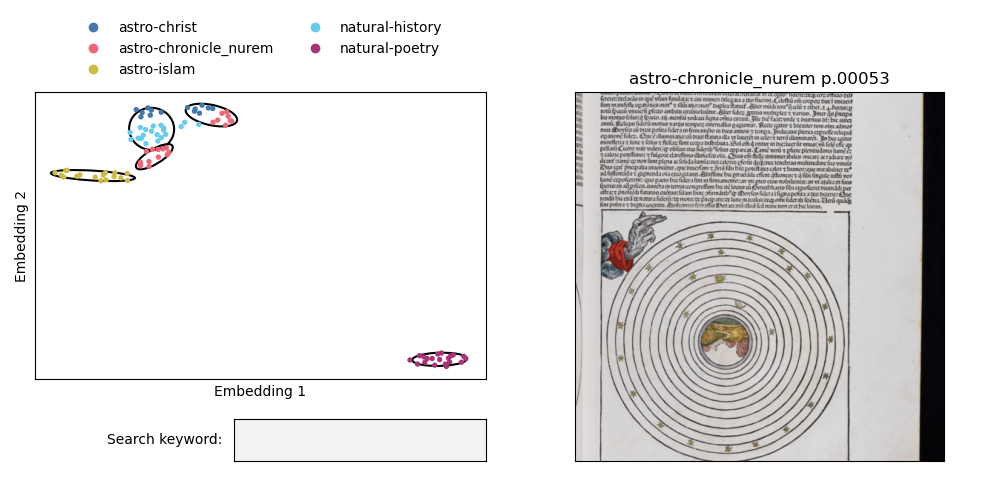

In [21]:
# Figure
gs = gridspec.GridSpec(5,10)
fig = plt.figure(figsize=(10,5))
lax = fig.add_subplot(gs[:-1,:5]) # Left axis - for scatterplot
rax = fig.add_subplot(gs[:,5:]) # Right axis - for image
sax = fig.add_subplot(gs[-1,2:5]) # searchbox axis
# Scatter plot for LHS
scatter = lax.scatter(x,y,c=manuscript_labels,s=8,cmap=cmap,zorder=50)
# Make it look nicer
lax.set_xlabel("Embedding 1")
lax.set_ylabel("Embedding 2")
lax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
# Legend
leg = lax.legend(scatter.legend_elements()[0],list(manuscript_label_to_name.values()),
                loc="lower center",
                bbox_to_anchor=(0.5,1.01),
                ncol=2,
                frameon=False)
# Plot clusters
cluster_perims = {}
for i, (mean, covar) in enumerate(zip(cluster_model.means_, cluster_model.covariances_)):
    v, w = linalg.eigh(covar)
    v = 2.5 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # as the DP will not use every component it has access to
    # unless it needs it, we shouldn't plot the redundant
    # components.
    if not np.any(clusters == i):
        continue

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, linewidth=1.5,fill=False,color='k',zorder=20)
    ell.set_clip_box(lax.bbox)
    cluster_perims[i] = lax.add_artist(ell)

img = rax.imshow(image_batch[0].permute(1, 2, 0))
# Plot an image
def plot_img_on_rax(ind):
    img.set_data(image_batch[ind].permute(1, 2, 0))
    rax.set_visible(True)
    rax.set_title("{} p.{}".format(manuscript_label_to_name.get(manuscript_labels[ind]),page_numbers[ind]))
plot_img_on_rax(np.random.randint(image_batch.shape[0]))
rax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
fig.tight_layout()

# Mouseover functionality
def hover(event):
    # if the mouse is over the scatter points
    if scatter.contains(event)[0]:
        # find out the index within the array from the event
        ind, = scatter.contains(event)[1]["ind"]
        # Check whether cursor overlaps with two or more scatter points. 
        if hasattr(ind,"__len__"):
            mx,my = event.xdata, event.ydata
            dists = (x[ind]-mx)**2+(y[ind]-my)**2
            ind = ind[np.argmin(dists)]
        # Show view and make it visible
        plot_img_on_rax(ind)
    # else:
    #     #if the mouse is not over a scatter point
    #     rax.set_visible(False)
    fig.canvas.draw_idle()
# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)    

# Textbox functionality
def submit(search_string):
    occurence_freqs = (np.array([search_string.lower() in words for words in trial_meta_data]) @ cluster_probs)/cluster_probs.sum(0)
    wts = occurence_freqs/occurence_freqs.max()
    for i,ellipse in cluster_perims.items():
        ellipse.set(edgecolor=cm.gray_r(wts[i]))

text_box = TextBox(sax,"Search keyword:  ")
text_box.on_submit(submit)

